In [2]:
import os
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF




In [3]:
original_data_df      =  pd.read_csv('data_100K/ml-100k/udata.csv')#, columns=['userID','movieID', 'rating', 'timestamp'])
data_df               =  original_data_df.copy()
data_df.columns       =  ['userID','movieID', 'rating', 'timestamp']
data_df.drop(columns=['timestamp'], inplace=True)

print(data_df.shape)
data_df.head(1)

FileNotFoundError: [Errno 2] No such file or directory: 'data_100K/ml-100k/udata.csv'

In [ ]:
# getting rating count (watched) for each movie filtering by movie with more than 20 user ratings (watching) and getting the top 10
watched_df = data_df.groupby('movieID')[['userID']].count().rename(columns={'userID': 'count'})
watched_df = watched_df[watched_df['count']>20]
print(watched_df.shape)

(927, 1)


In [ ]:
original_item_df             =   pd.read_csv('data_100K/ml-100k/uitem.csv', sep='|', header=None).iloc[:,0:5].drop(columns=[3])
item_df            
item_df.columns     =   ['movieID', 'movieTit', 'release', 'url']
item_df.drop(columns=   ['release', 'url'], inplace=True)
item_df.head(1)

,movieID,movieTit
0,1,Toy Story (1995)


In [ ]:
main_df = pd.merge(data_df, item_df, how='inner', on='movieID')
#filter movies which watched less than 20 people
main_df = pd.merge(main_df, watched_df, how='inner', on='movieID')
main_df

,userID,movieID,rating,movieTit,count
0,186,302,3,L.A. Confidential (1997),297
1,191,302,4,L.A. Confidential (1997),297
2,49,302,4,L.A. Confidential (1997),297
3,54,302,4,L.A. Confidential (1997),297
4,62,302,3,L.A. Confidential (1997),297
...,...,...,...,...,...
94722,829,1121,4,"Umbrellas of Cherbourg, The (Parapluies de Che...",21
94723,523,1121,5,"Umbrellas of Cherbourg, The (Parapluies de Che...",21
94724,878,1121,2,"Umbrellas of Cherbourg, The (Parapluies de Che...",21
94725,492,1121,2,"Umbrellas of Cherbourg, The (Parapluies de Che...",21


In [ ]:
ratings=main_df.pivot(index='userID', columns='movieID', values='rating').fillna(ratings.median())
ratings

movieID,1,2,3,4,5,6,7,8,9,10,...,1226,1228,1231,1240,1244,1258,1267,1284,1315,1411
userID,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,4.0,3.0,2.5,4.0,3.0,3.0,3.0,3.0,3.0,3.0
2,4.0,3.0,3.0,4.0,3.0,4.0,4.0,4.0,4.0,2.0,...,4.0,3.0,2.5,4.0,3.0,3.0,3.0,3.0,3.0,3.0
3,4.0,3.0,3.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,...,4.0,3.0,2.5,4.0,3.0,3.0,3.0,3.0,3.0,3.0
4,4.0,3.0,3.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,...,4.0,3.0,2.5,4.0,3.0,3.0,3.0,3.0,3.0,3.0
5,4.0,3.0,3.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,...,4.0,3.0,2.5,4.0,3.0,3.0,3.0,3.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,4.0,3.0,3.0,4.0,3.0,4.0,4.0,4.0,5.0,4.0,...,4.0,3.0,2.5,4.0,3.0,3.0,3.0,3.0,3.0,3.0
940,4.0,3.0,3.0,2.0,3.0,4.0,4.0,5.0,3.0,4.0,...,4.0,3.0,2.5,4.0,3.0,3.0,3.0,3.0,3.0,3.0
941,5.0,3.0,3.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,...,4.0,3.0,2.5,4.0,3.0,3.0,3.0,3.0,3.0,3.0


In [ ]:
#P_matrixes  = []
Q_matrixes  = []
#R_hats      = []
errors      = []

for i in range(2,100):
    print(f'COMPONENT NUMBER: {i}---------------------------------------------------------------------------------------------------')
    nmf_model       = NMF(n_components=i, max_iter=10000)
    nmf_model.fit(ratings)
    Q_matrix        = nmf_model.components_
    #P_matrix    = nmf_model.transform(ratings)
    #R_hat           = np.dot(P_matrix,Q_matrix)
    #R_hat           = pd.DataFrame(data=R_hat)
                        
    error = nmf_model.reconstruction_err_

    Q_matrixes.append(Q_matrix)
    #P_matrixes.append(P_matrix)
    #R_hats.append(R_hat)
    errors.append(error)

    with open(f'nmf_model_comp2_{i}.pkl',mode='wb') as file:
        pickle.dump(nmf_model,file)


COMPONENT NUMBER: 2---------------------------------------------------------------------------------------------------
COMPONENT NUMBER: 3---------------------------------------------------------------------------------------------------
COMPONENT NUMBER: 4---------------------------------------------------------------------------------------------------
COMPONENT NUMBER: 5---------------------------------------------------------------------------------------------------
COMPONENT NUMBER: 6---------------------------------------------------------------------------------------------------
COMPONENT NUMBER: 7---------------------------------------------------------------------------------------------------
COMPONENT NUMBER: 8---------------------------------------------------------------------------------------------------
COMPONENT NUMBER: 9---------------------------------------------------------------------------------------------------
COMPONENT NUMBER: 10----------------------------

236.6512362246484

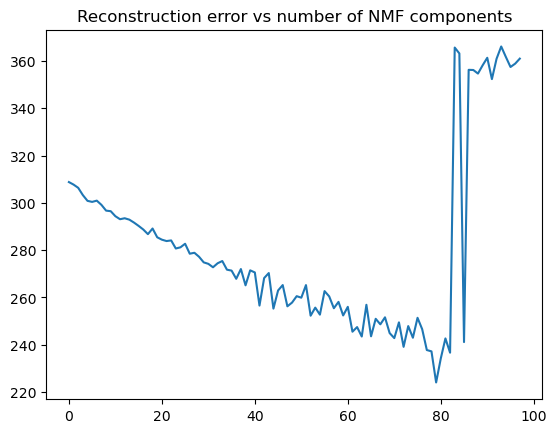

In [ ]:
plt.plot(errors)
plt.title('Reconstruction error vs number of NMF components')
errors[82]

225.1981666876233

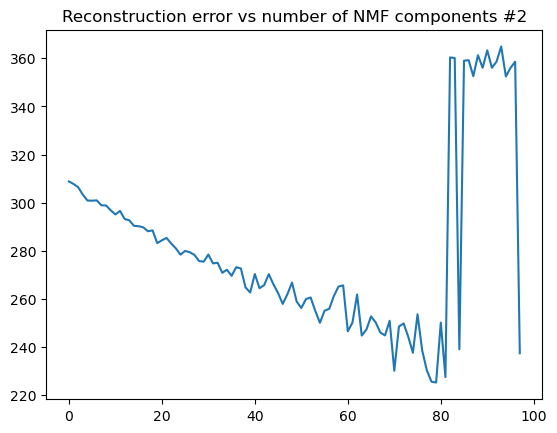

In [294]:
plt.plot(errors)
plt.title('Reconstruction error vs number of NMF components #2')
errors[79]